In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [2]:
import re
import datetime
from pyspark.sql import Row
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
def apache_time(s):
    return datetime.datetime(
        int(s[7:11]),
        month_map[s[3:6]],
        int(s[0:2]),
        int(s[12:14]),
        int(s[15:17]),
        int(s[18:20]))

In [3]:
# (1a) Parsing Each Log Line
def parse_apache_log_line(logline):
    m = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if m is None: return (logline, 0)
    return (Row(
        host = m.group(1),
        client_id = m.group(2),
        user_id = m.group(3),
        date_time = apache_time(m.group(4)),
        method = m.group(5),
        endpoint = m.group(6),
        protocol = m.group(7),
        response_code = int(m.group(8)),
        content_size = int(m.group(9)) if m.group(9) != '-' else 0), 1)

In [4]:
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'

In [5]:
from google.colab import drive
drive.mount('/content/modules', force_remount=True)

Mounted at /content/modules


In [6]:
# (1b) Configuration and Initial RDD Creation
logFile = "/content/modules/My Drive/NASAlog.txt"
def parseLogs():
    parsed_logs = sc.textFile(logFile).map(parse_apache_log_line).cache()
    access_logs = parsed_logs.filter(lambda s: s[1] == 1).map(lambda s: s[0]).cache()
    failed_logs = parsed_logs.filter(lambda s: s[1] == 0).map(lambda s: s[0])
    failed_logs_count = failed_logs.count()
    if failed_logs_count > 0:
        print('Number of invalid loglines: %d' % failed_logs.count())
        for line in failed_logs.take(20):
            print('Invalid logline: %s' % line)
    print('Read %d lines, successfully parsed %d lines, failed to parse %d lines'
        % (parsed_logs.count(), access_logs.count(), failed_logs.count()))
    return parsed_logs, access_logs, failed_logs
parsed_logs, access_logs, failed_logs = parseLogs()

Number of invalid loglines: 58
Invalid logline: wxs6-7.worldaccess.nl - - [02/Jul/1995:08:09:27 -0400] "GET / /   HTTP/1.0" 200 7074
Invalid logline: wxs6-7.worldaccess.nl - - [02/Jul/1995:08:11:20 -0400] "GET / /facts/facts.html HTTP/1.0" 200 7074
Invalid logline: s29.abqslip.indirect.com - - [02/Jul/1995:14:24:26 -0400] "GET /htbin/wais.pl?Wake Shield HTTP/1.0" 200 7020
Invalid logline: pipe3.nyc.pipeline.com - - [02/Jul/1995:22:24:41 -0400] "GET /shuttle/countdown/dy �?shuttle%20tracking HTTP/1.0" 404 -
Invalid logline: pipe3.nyc.pipeline.com - - [02/Jul/1995:22:25:48 -0400] "GET /shuttle/countdown/dy �?tracking%20station HTTP/1.0" 404 -
Invalid logline: wxs6-4.worldaccess.nl - - [03/Jul/1995:08:14:40 -0400] "GET / /   HTTP/1.0" 304 0
Invalid logline: atl4-m52.ed.ac.uk - - [03/Jul/1995:09:31:12 -0400] "GET /images/NASA-logosmall.gif align=left HTTP/1.0" 200 786
Invalid logline: atl4-m52.ed.ac.uk - - [03/Jul/1995:09:32:20 -0400] "GET /images/NASA-logosmall.gif align=left HTTP/1.0" 20

In [7]:
# (1c) Data Cleaning
APACHE_ACCESS_LOG_PATTERN = (
    r"^([^ ]+)" # host
    r" ([^ ]+)" # client_id
    r" ([^ ]+)" # user_id
    r" \[([^]]*)\]" # date_time
    r" \"(GET|HEAD|POST)" # method
    r" ([^ ]+)" # endpoint
    r"(?:[ ]*[^ ]+[ ]*)*?"
    r"( HTTP/(?:V|)1.0|)" # protocol
    r"\" ([0-9]+)" # response_code
    r" ([0-9]+|-)" # content_size
    r"$"
)
log_lines = 0
failed_lines = 0
with open(logFile, encoding="latin1") as log_file:
    while log_line := log_file.readline():
        log_line = log_line[:-1]
        m = re.search(APACHE_ACCESS_LOG_PATTERN, log_line)
        if not m: failed_lines += 1
        log_lines += 1
print(log_lines, failed_lines)

314876 0


In [8]:
parsed_logs, access_logs, failed_logs = parseLogs()

Read 314876 lines, successfully parsed 314876 lines, failed to parse 0 lines


In [9]:
# (2a) Example: Content Size Statistics
content_sizes = access_logs.map(lambda log: log.content_size).cache()
print('Content Size Avg: %i, Min: %i, Max: %s'
    % (content_sizes.reduce(lambda a, b : a + b) / content_sizes.count(),
       content_sizes.min(),
       content_sizes.max()))

Content Size Avg: 23542, Min: 0, Max: 2973350


In [10]:
# (2b) Example: Response Code Analysis
response_code_to_count =  ( access_logs
                            .map(lambda log: (log.response_code, 1))
                            .reduceByKey(lambda total, count : total + count)
                            .cache()
                          )
response_code_to_count_list = response_code_to_count.take(100)
print('Found %d response codes' % len(response_code_to_count_list))
print('Response Code Counts: %s' % response_code_to_count_list)

Found 7 response codes
Response Code Counts: [(200, 283992), (304, 17842), (302, 11354), (404, 1621), (500, 53), (403, 13), (501, 1)]


[200, 304, 302, 404, 500, 403, 501]
[0.9019169450831438, 0.05666357550273759, 0.03605863895628755, 0.005148058283260712, 0.00016832022764516825, 4.1286093573343156e-05, 3.1758533517956276e-06]


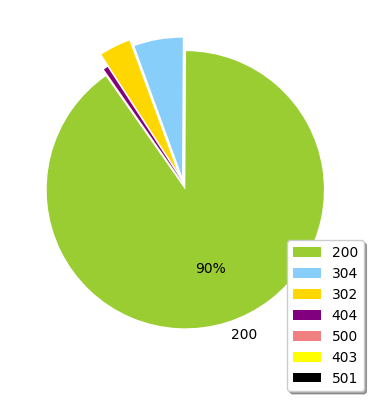

In [11]:
# (2c) Example: Response Code Graphing with matplotlib
import matplotlib.pyplot as plt
labels = response_code_to_count.map(lambda r: r[0]).collect()
print(labels)
count = access_logs.count()
fracs = response_code_to_count.map(lambda r: (float(r[1]) / count)).collect()
print(fracs)
def pie_pct_format(value):
    return '' if value < 7 else '%.0f%%' % value
fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black']
explode = (0.05, 0.05, 0.1, 0, 0, 0, 0)
patches, texts, autotexts = plt.pie(
    fracs, labels=labels, colors=colors,
    explode=explode, autopct=pie_pct_format,
    shadow=False, startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('') # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(0.80, -0.1), shadow=True)
#display(fig)

In [12]:
# (2d) Example: Frequent Hosts
host_count_pair_tuple = access_logs.map(lambda log: (log.host, 1))
host_sum = host_count_pair_tuple.reduceByKey(lambda a, b : a + b)
host_more_than_10 = host_sum.filter(lambda s: s[1] > 10)
hosts_pick_20 = host_more_than_10.map(lambda s: s[0]).take(20)
print('Any 20 hosts that have accessed more than 10 times: %s' % hosts_pick_20)

Any 20 hosts that have accessed more than 10 times: ['j10.ptl5.jaring.my', 'freenet.edmonton.ab.ca', 'www-a1.proxy.aol.com', '129.188.154.200', 'www-d1.proxy.aol.com', 'www-b2.proxy.aol.com', 'ip109.phx.primenet.com', 'foley.ripco.com', 'remote14.compusmart.ab.ca', 'tularcitos.tularcitos.cusd.k12.ca.us', 'ppp179.iadfw.net', 'ip16-004.phx.primenet.com', 'www-d2.proxy.aol.com', 'alyssa.prodigy.com', 'gateway.ps.net', 'www-b4.proxy.aol.com', 'piweba1y.prodigy.com', 'world.std.com', '139.169.183.30', 'slip80.slip.pacifier.com']


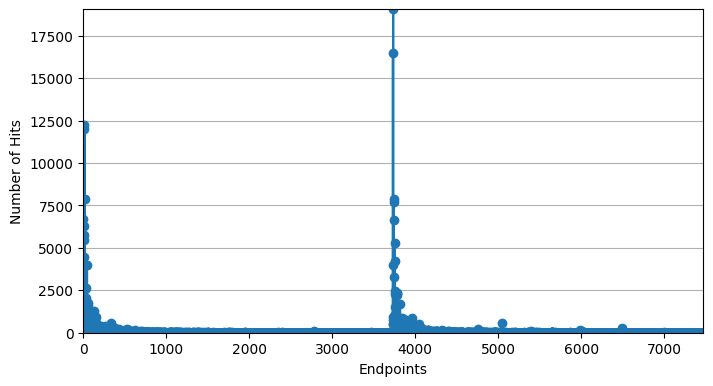

In [13]:
# (2e) Example: Visualizing Endpoints
endpoints = access_logs.map(lambda log: (log.endpoint, 1)).reduceByKey(lambda a, b: a + b).cache()
ends = endpoints.map(lambda e: e[0]).collect()
counts = endpoints.map(lambda e: e[1]).collect()
fig, ax = plt.subplots(figsize=(8, 4.2), facecolor='white', edgecolor='white')
#ax.set_xticks(range(len(ends)))
#ax.set_xticklabels(ends, rotation=45, ha="right")
ax.set_xlim([0, len(ends)])
ax.set_ylim([0, max(counts)])
ax.grid(True, which='major', axis='y')
ax.set_xlabel("Endpoints")
ax.set_ylabel("Number of Hits")
ax.plot(range(len(ends)), counts, marker="o", linestyle="-")
plt.show()

In [14]:
# (2f) Example: Top Endpoints
endpoint_counts = access_logs.map(lambda log: (log.endpoint, 1)).reduceByKey(lambda a, b : a + b)
top_endpoints = endpoint_counts.takeOrdered(10, lambda s: -1 * s[1])
print('Top Ten Endpoints: %s' % top_endpoints)

Top Ten Endpoints: [('/images/NASA-logosmall.gif', 19065), ('/images/KSC-logosmall.gif', 16502), ('/shuttle/countdown/count.gif', 12230), ('/shuttle/countdown/', 11992), ('/images/MOSAIC-logosmall.gif', 7912), ('/images/ksclogo-medium.gif', 7902), ('/images/USA-logosmall.gif', 7887), ('/images/WORLD-logosmall.gif', 7729), ('/shuttle/missions/sts-71/images/images.html', 6718), ('/shuttle/missions/sts-71/sts-71-patch-small.gif', 6628)]


In [15]:
# (3a) Exercise: Top Ten Error Endpoints
# What are the top ten endpoints which did not have return code 200?
not_200 = access_logs.filter(lambda log: log.response_code != 200)
endpoint_count_pair_tuple = not_200.map(lambda log: (log.endpoint, 1))
endpoint_sum = endpoint_count_pair_tuple.reduceByKey(lambda acc, count: acc + count)
top_ten_err_URLs = endpoint_sum.takeOrdered(10, lambda e: -e[1])
print(endpoint_sum.count())
print('Top Ten failed URLs: %s' % top_ten_err_URLs)

4690
Top Ten failed URLs: [('/images/NASA-logosmall.gif', 2404), ('/images/KSC-logosmall.gif', 1806), ('/shuttle/countdown/', 944), ('/images/MOSAIC-logosmall.gif', 845), ('/images/USA-logosmall.gif', 830), ('/images/WORLD-logosmall.gif', 811), ('/shuttle/countdown/count.gif', 777), ('/images/ksclogo-medium.gif', 751), ('/shuttle/countdown/liftoff.html', 590), ('/shuttle/missions/sts-71/sts-71-patch-small.gif', 543)]


In [16]:
# (3b) Exercise: Number of Unique Hosts
# How many unique hosts are there in the entire log?
hosts = access_logs.map(lambda log: (log.host, 1))
unique_hosts = hosts.groupByKey()
unique_hosts_count = unique_hosts.count()
print('Unique hosts: %d' % unique_hosts_count)

Unique hosts: 22013


In [17]:
# (3c) Exercise: Number of Unique Daily Hosts (using Python set())
# How many unique hosts are there in the entire log on a day-by-day basis.
day_to_host_pair_tuple = access_logs.map(lambda log: (log.date_time.day, {log.host}))
day_grouped_hosts = day_to_host_pair_tuple.reduceByKey(lambda accum, value: accum.union(value))
day_host_count = day_grouped_hosts.map(lambda x: (x[0], len(x[1])))
daily_hosts = day_host_count
daily_hosts.cache()
daily_hosts_list = daily_hosts.takeOrdered(4)
print('Unique hosts per day: %s' % daily_hosts_list)

Unique hosts per day: [(2, 4859), (3, 7336), (4, 5524), (5, 7383)]


In [18]:
# (3c) Exercise: Number of Unique Daily Hosts (using distinct)
# How many unique hosts are there in the entire log on a day-by-day basis.
unique_day_hosts = access_logs.map(lambda log: (log.date_time.day, log.host)).distinct()
daily_host_count = unique_day_hosts.map(lambda x: (x[0], 1)).reduceByKey(lambda total, count: total + count)
daily_host_count.cache()
daily_hosts_list = daily_host_count.takeOrdered(4, key=lambda x: x[0])
print('Unique hosts per day: %s' % daily_hosts_list)

Unique hosts per day: [(2, 4859), (3, 7336), (4, 5524), (5, 7383)]


[2, 3, 4, 5]
[4859, 7336, 5524, 7383]


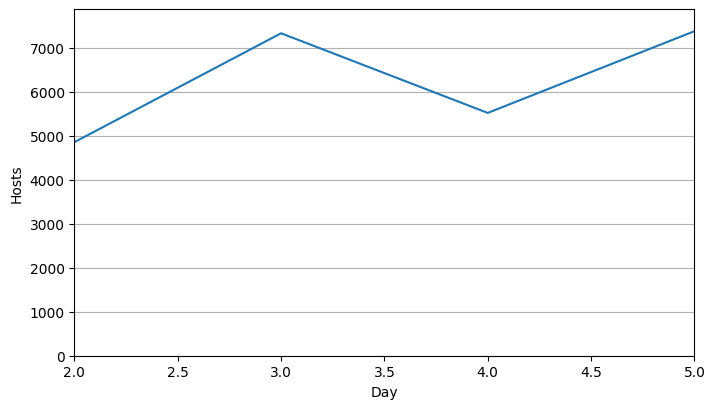

In [19]:
# (3d) Exercise: Visualizing the Number of Unique Daily Hosts
days_with_hosts = daily_hosts.sortBy(lambda x: x[0]).map(lambda x: x[0]).collect()
hosts           = daily_hosts.sortBy(lambda x: x[0]).map(lambda x: x[1]).collect()
print(days_with_hosts)
print(hosts)
fig = plt.figure(figsize=(8,4.5), facecolor='white', edgecolor='white')
plt.axis([min(days_with_hosts), max(days_with_hosts), 0, max(hosts)+500])
plt.grid(which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Hosts')
plt.plot(days_with_hosts, hosts)

In [20]:
# (3e) Exercise: Average Number of Daily Requests per Hosts
day_and_host_tuple = access_logs.map(lambda log: (log.date_time.day, 1))
grouped_by_day = day_and_host_tuple.reduceByKey(lambda acc, value: acc + value)
sorted_by_day = grouped_by_day.join(daily_hosts).map(lambda x: (x[0], x[1][0] // x[1][1]))
avg_daily_req_per_host = sorted_by_day.sortBy(lambda x: x[0])
avg_daily_req_per_host.cache()
avg_daily_req_per_host_list = avg_daily_req_per_host.collect()
print('Average number of daily requests per Hosts is %s' % avg_daily_req_per_host_list)
#Average number of daily requests per Hosts is [(2, 12), (3, 12), (4, 12), (5, 12)]

Average number of daily requests per Hosts is [(2, 12), (3, 12), (4, 12), (5, 12)]


[2, 3, 4, 5]
[12, 12, 12, 12]


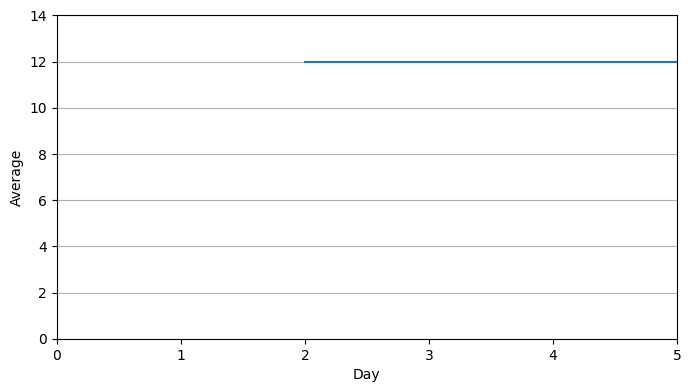

In [21]:
# (3f) Exercise: Visualizing the Average Daily Requests per Unique Host
days_with_avg = avg_daily_req_per_host.sortBy(lambda x: x[0]).map(lambda x: x[0]).collect()
avgs          = avg_daily_req_per_host.sortBy(lambda x: x[0]).map(lambda x: x[1]).collect()
print(days_with_avg)
#[2, 3, 4, 5]
print(avgs)
#[12, 12, 12, 12]
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(days_with_avg), 0, max(avgs)+2])
plt.grid(True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Average')
plt.plot(days_with_avg, avgs)

In [22]:
# (4a) Exercise: Counting 404 Response Codes
bad_records = access_logs.filter(lambda log: log.response_code == 404)
bad_records.cache()
print('Found %d 404 URLs' % bad_records.count())
#Found 1621 404 URLs

Found 1621 404 URLs


In [23]:
# (4b) Exercise: Listing 404 Response Code Records
# How many 404 records are in the log?
bad_endpoints = bad_records.map(lambda log: log.endpoint)
bad_unique_endpoints = bad_endpoints.distinct()
bad_unique_endpoints_pick_40 = bad_unique_endpoints.takeOrdered(40)
print('404 URLS: %s' % bad_unique_endpoints_pick_40)
print(len(set(bad_unique_endpoints_pick_40)))
#40

404 URLS: ['/%3A//spacelink.msfc.nasa.gov', '/%7Eadverts/ibm/ad1/banner.gif', '//history/apollo/apollo-13/apollo-13html', '//spacelink.msfc.nasa.gov/', '//spacelink.msfc.nasa.gov:70/00/About.Spacelink/File.Transfer.Protocols', '/11/history/apollo/images/', '/://spacelink.msfc.nasa.gov', '/:/spacelink.msfc.nasa.gov', '/DataSources/MetData.html', '/Government/Research_Labs/NASA/Kennedy_Space_Center/', '/HISTOTY/APOLLO/APOLLO-13/', '/KSC.', '/KSC.HTML', '/KSC.HTML/', '/LDAR/LDARhp.html', '/NASA_TV/NASA_TV.html', '/SDG/Experimental/demoweb/return.gif', '/SHUTTLE', '/SHUTTLE/COUNTDOWN/', '/SHUTTLE/MISSION/STS-71/IMAGES/IMAGES.HTML', '/SHUTTLE/MISSIONS/STS-71/IMAGES/IMAGES.HTML', '/Science/Space/Missions/Magellan_Mission_to_Venus/', '/Tools/Bars/Front/main_bar.gif', '/Tools/Icons/Help/hw.embossed.grey.gif', '/apollo-13.html', '/att.net/dir800/', '/bann04.gif', '/base-ops/procurement/kscbus.htm', '/bigspot.com', '/cleve.net/cnnavbar.gif', '/daily/ecs/s71e0003.jpg', '/daily/ecs/s71e0004.jpg', 

In [24]:
# (4c) Exercise: Listing the Top Twenty 404 Response Code Endpoints
bad_endpoints_count_pair_tuple = bad_records.map(lambda log: (log.endpoint, 1))
bad_endpoints_sum = bad_endpoints_count_pair_tuple.reduceByKey(lambda total, count: total + count)
bad_endpoints_top_20 = bad_endpoints_sum.sortBy(lambda x: -x[1]).take(20)
print('Top Twenty 404 URLs: %s' % bad_endpoints_top_20)

Top Twenty 404 URLs: [('/pub/winvn/readme.txt', 84), ('/pub/winvn/release.txt', 82), ('/history/apollo/publications/sp-350/sp-350.txt~', 67), ('/shuttle/resources/orbiters/atlantis.gif', 65), ('/shuttle/missions/sts-71/images/KSC-95EC-0916.txt', 55), ('/://spacelink.msfc.nasa.gov', 47), ('/history/apollo/a-001/a-001-patch-small.gif', 46), ('/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif', 44), ('/history/apollo/sa-1/sa-1-patch-small.gif', 42), ('/history/apollo/apollo-13.html', 36), ('/images/crawlerway-logo.gif', 31), ('/shuttle/missions/sts-68/ksc-upclose.gif', 29), ('/histroy/apollo-13/apollo-13.html', 20), ('/shuttle/missions/technology/sts-newsref/stsref-toc.html', 19), ('/history/apollo/sa-9/sa-9-patch-small.gif', 19), ('/shuttle/resources/orbiters/challenger.gif', 18), ('/shuttle/technology/images/tps_mods-small.gif', 14), ('/history/apollo/images/little-joe.jpg', 13), ('/history/apollo/sa-2/sa-2-patch-small.gif', 12), ('/history/apollo/pad-abort-test-1/images

In [25]:
# (4d) Exercise: Listing the Top Twenty-Five 404 Response Code Hosts
err_hosts_count_pair_tuple = bad_records.map(lambda log: (log.host, 1))
err_hosts_sum = err_hosts_count_pair_tuple.reduceByKey(lambda total, count: total + count)
err_hosts_top_25 = err_hosts_sum.sortBy(lambda x: -x[1]).take(25)
print('Top 25 hosts that generated errors: %s' % err_hosts_top_25)

Top 25 hosts that generated errors: [('piweba3y.prodigy.com', 29), ('128.158.48.26', 26), ('espresso.sd.inri.com', 25), ('www-b6.proxy.aol.com', 22), ('ch025.chance.berkeley.edu', 17), ('ffong-sl.cc.emory.edu', 15), ('www-d4.proxy.aol.com', 15), ('alyssa.prodigy.com', 14), ('cpcug.org', 14), ('advantis.vnet.ibm.com', 13), ('sta07.oit.unc.edu', 12), ('128.158.32.107', 12), ('www-b5.proxy.aol.com', 11), ('dialup-2-89.gw.umn.edu', 11), ('www-d1.proxy.aol.com', 10), ('ten-nash.ten.k12.tn.us', 10), ('dd13-025.compuserve.com', 10), ('w20-575-4.mit.edu', 10), ('ix-bal2-14.ix.netcom.com', 9), ('disc.dna.affrc.go.jp', 9), ('wstabnow.gsfc.nasa.gov', 9), ('www-b2.proxy.aol.com', 8), ('gatekeeper.mitre.org', 8), ('www-b1.proxy.aol.com', 8), ('dawn14.cs.berkeley.edu', 8)]


In [26]:
# (4e) Exercise: Listing 404 Response Codes per Day
err_date_count_pair_tuple = bad_records.map(lambda log: (log.date_time.day, 1))
err_date_sum = err_date_count_pair_tuple.reduceByKey(lambda total, count: total + count)
err_date_sorted = err_date_sum.sortBy(lambda x: x[0])
err_date_sorted.cache()
err_by_date = err_date_sorted.collect()
print('404 Errors by day: %s' % err_by_date)
#404 Errors by day: [(2, 291), (3, 474), (4, 359), (5, 497)]

404 Errors by day: [(2, 291), (3, 474), (4, 359), (5, 497)]


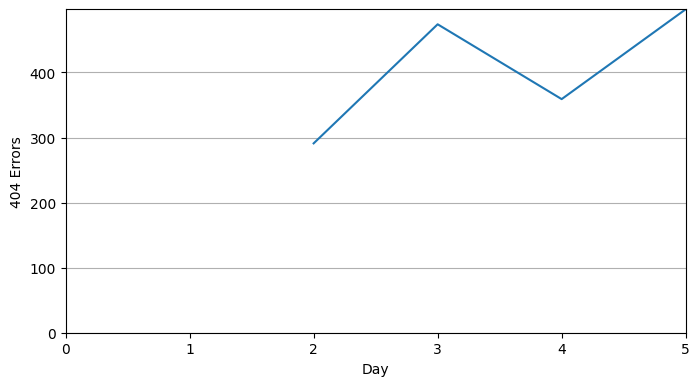

In [27]:
# (4f) Exercise: Visualizing the 404 Response Codes by Day
days_with_errors_404 = err_date_sorted.sortBy(lambda x: x[0]).map(lambda x: x[0]).collect()
errors_404_by_day    = err_date_sorted.sortBy(lambda x: x[0]).map(lambda x: x[1]).collect()
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(days_with_errors_404), 0, max(errors_404_by_day)])
plt.grid(True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('404 Errors')
plt.plot(days_with_errors_404, errors_404_by_day)

In [28]:
# (4g) Exercise: Hourly 404 Response Codes
hour_count_pair_tuple = bad_records.map(lambda log: (log.date_time.hour, 1))
hour_records_sum = hour_count_pair_tuple.reduceByKey(lambda total, count: total + count)
hour_records_sorted = hour_records_sum.sortBy(lambda x: x[0])
hour_records_sorted.cache()
err_hour_list = hour_records_sorted.collect()
print('404 Errors by hour: %s' % err_hour_list)
#404 Errors by hour:
#[(0, 72), (1, 77), (2, 37), (3, 30), (4, 13), (5, 22),
#(6, 26), (7, 42), (8, 72), (9, 104), (10, 64), (11, 68),
#(12, 69), (13, 52), (14, 98), (15, 99), (16, 121), (17, 76),
#(18, 101), (19, 54), (20, 58), (21, 52), (22, 73), (23, 141)]

404 Errors by hour: [(0, 72), (1, 77), (2, 37), (3, 30), (4, 13), (5, 22), (6, 26), (7, 42), (8, 72), (9, 104), (10, 64), (11, 68), (12, 69), (13, 52), (14, 98), (15, 99), (16, 121), (17, 76), (18, 101), (19, 54), (20, 58), (21, 52), (22, 73), (23, 141)]


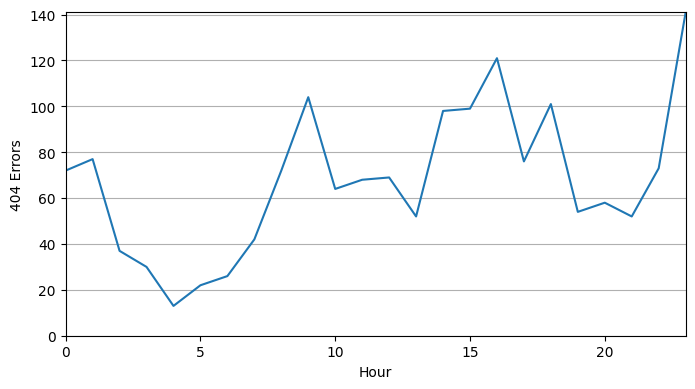

In [29]:
# (4h) Exercise: Visualizing the 404 Response Codes by Hour
hours_with_errors_404 = hour_records_sorted.sortBy(lambda x: x[0]).map(lambda x: x[0]).collect()
errors_404_by_hours   = hour_records_sorted.sortBy(lambda x: x[0]).map(lambda x: x[1]).collect()
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(hours_with_errors_404), 0, max(errors_404_by_hours)])
plt.grid(True, which='major', axis='y')
plt.xlabel('Hour')
plt.ylabel('404 Errors')
plt.plot(hours_with_errors_404, errors_404_by_hours)